## COMPAS Analysis using Aequitas
<a id='top_cell'></a>
Recent work in the Machine Learning community has raised concerns about the risk of unintended bias in Algorithmic Decision-Making systems, affecting individuals unfairly. While many bias metrics and fairness definitions have been proposed in recent years, the community has not reached a consensus on which definitions and metrics should be used, and there has been very little empirical analyses of real-world problems using the proposed metrics.

We present the Aequitas toolkit as an intuitive addition to the machine learning workflow, enabling users to to seamlessly test models for several bias and fairness metrics in relation to multiple population groups. We believe the tool will faciliate informed and equitable decision-making around developing and deploying predictive risk-assessment tools for both machine learnining practitioners and policymakers, allowing researchers and program managers to answer a host of questions related to machine learning models, including:

- [What biases exist in my model?](#existing_biases)
    - [What is the distribution of groups, predicted scores, and labels across my dataset?](#xtab)
    - [What are bias metrics across groups?](#xtab_metrics)
    - [How do I interpret biases in my model?](#interpret_bias)
    - [How do I visualize biases in my model?](#bias_viz)

- [What levels of disparity exist between population groups?](#disparities)
    - [How does the selected reference group affect disparity calculations?](#disparity_calc)
    - [How do I interpret calculated disparity ratios?](#interpret_disp)
    - [How do I visualize disparities in my model?](#disparity_viz)

- [How do I assess model fairness??](#fairness)
    - [How do I interpret parities?](#interpret_fairness)
    - [How do I visualize bias metric parity?](#fairness_group_viz)
    - [How do I visualize parity between groups in my model?](#fairness_disp_viz)


We apply the toolkit to the COMPAS dataset reported on by ProPublica below.

### Background

In 2016, ProPublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based on [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset from the ProPublica GitHub repo, we demostrate the use of the Aequitas bias reporting tool.

Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the most widesly utilized risk assessment tools/ algorithms within the criminal justice system for guiding decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

In [1]:
!pip install "aequitas==1.0.0" &> /dev/null

import pandas as pd
import seaborn as sns
from aequitas.audit import Audit
from aequitas.fairness import Fairness
import aequitas.plot as ap

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("https://github.com/dssg/aequitas/raw/master/examples/data/compas_for_aequitas.csv")
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


In [3]:
df.shape

(7214, 6)

## Pre-Aequitas: Exploring the COMPAS Dataset

__Risk assessment by race__

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of "low" risk according to COMPAS, while a 1 indicates "high" or "medium" risk.

This categorization is based on ProPublica's interpretation of Northpointe's practioner guide:

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range
    garner more interest from supervision agencies than low scores, as a low score would suggest
    there is little risk of general recidivism,” so we considered scores any higher than “low” to
    indicate a risk of recidivism."

In the bar charts below, we see a large difference in how these scores are distributed by race, with a majority of white and Hispanic people predicted as low risk (score = 0) and a majority of black people predicted high and medium risk (score = 1). We also see that while the majority of people in age categories over 25 are predicted as low risk (score = 0), the majority of people below 25 are predicted as high and medium risk (score = 1).

In [4]:
aq_palette = sns.diverging_palette(225, 35, n=2)

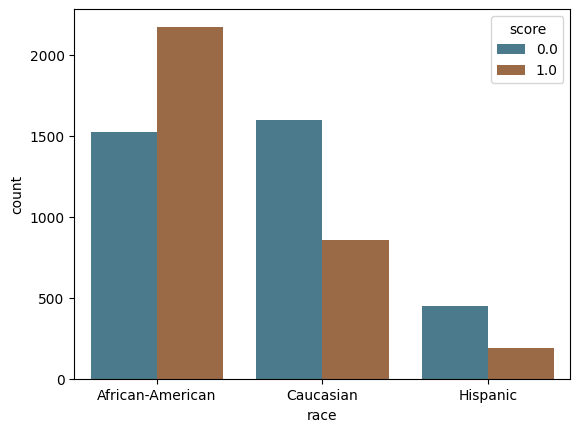

In [5]:
by_race = sns.countplot(x="race", hue="score", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

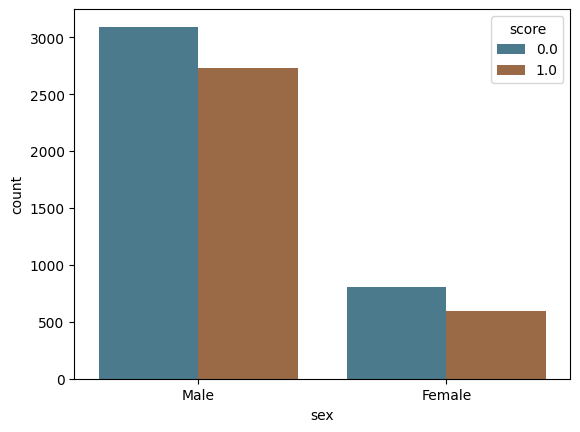

In [6]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

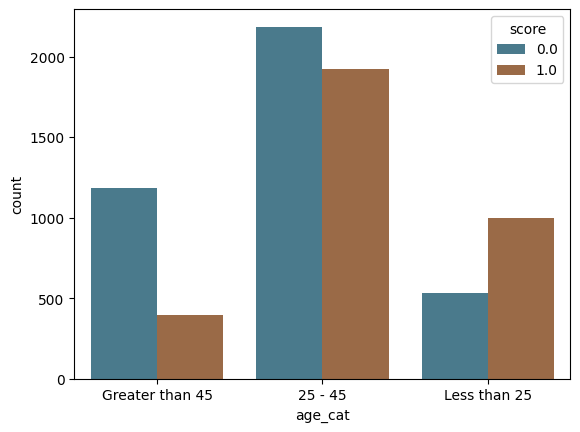

In [7]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=aq_palette)

__Levels of recidivism__

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race.

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"




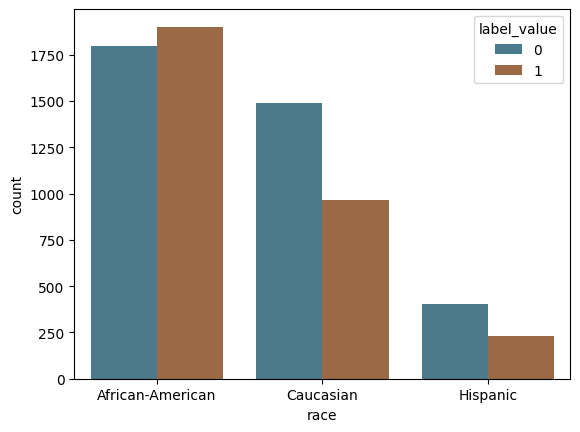

In [8]:
label_by_race = sns.countplot(x="race", hue="label_value", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=aq_palette)

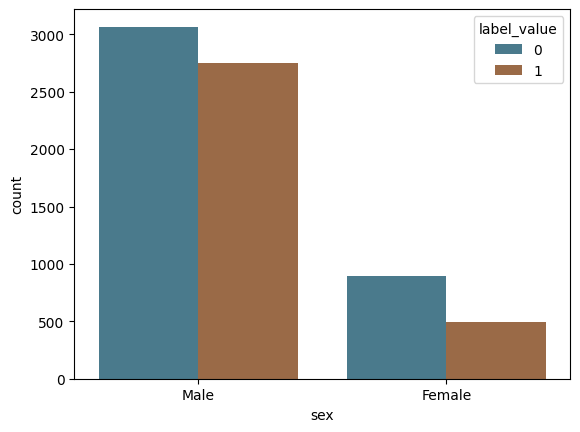

In [9]:
label_by_age = sns.countplot(x="sex", hue="label_value", data=df, palette=aq_palette)

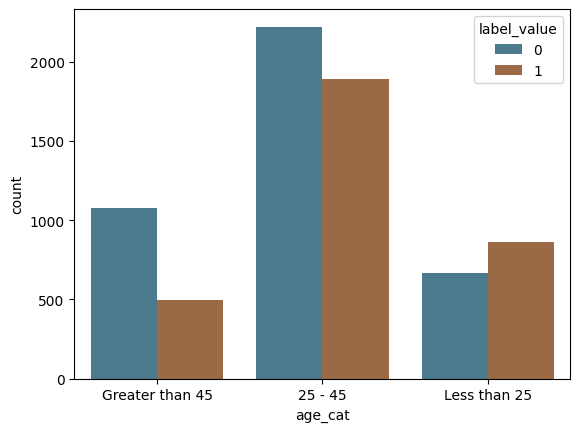

In [10]:
label_by_sex = sns.countplot(x="age_cat", hue="label_value", data=df, palette=aq_palette)

## Putting Aequitas to the task

The graphs above show the base rates for recidivism are higher for black defendants compared to white defendants (.51 vs .39), though the predictions do not match the base rates.

Practitioners face the challenge of determining whether or not such patterns reflect bias or not. The fact that there are multiple ways to measure bias adds complexity to the decision-making process. With Aequitas, we provide a tool that automates the reporting of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes:

`Group()`: Define groups

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.


### Data Formatting

Data for this example was preprocessed for compatibility with Aequitas. **The Aequitas tool always requires a `score` column and requires a binary `label_value` column for supervised metrics**, (i.e., False Discovery Rate, False Positive Rate, False Omission Rate, and False Negative Rate).

Preprocessing includes but is not limited to checking for mandatory `score` and `label_value` columns as well as at least one column representing attributes specific to the data set. See [documentation](../input_data.html) for more information about input data.

Note that while `entity_id` is not necessary for this example, Aequitas recognizes `entity_id` as a reserve column name and will not recognize it as an attribute column.

[Back to Top](#top_cell)
<a id='existing_biases'></a>

## What biases exist in my model?

### _Aequitas Group() Class_

<a id='xtab'></a>

### What is the distribution of groups, predicted scores, and labels across my dataset?

Aequitas's `Group()` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population.

<a id='counts_description'></a>
The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

#### Group Counts Calculated:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' |
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

#### Absolute Metrics Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


**Note**: The **`get_crosstabs()`** method expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include `race`, `sex` and `age_cat`.

In [11]:
audit = Audit(df.drop(columns=["entity_id"]), label_column="label_value")
audit.audit()

[Back to Top](#top_cell)
<a id='xtab_metrics'></a>

### What are bias metrics across groups?

Once you have run the `Group()` class **`get_crosstabs()`** method, you'll have a dataframe of the [group counts](#counts_description) and [group value bias metrics](#counts_description).

The `Group()` class has a **`list_absolute_metrics()`** method, which you can use for faster slicing to view just  counts or bias metrics.

#### View calculated counts across sample population groups

In [12]:
audit.confusion_matrix

pp    pn   fp    fn    tn    tp  \
attribute_name attribute_value                                       
race           African-American  2174  1522  805   532   990  1369   
               Asian                8    24    2     3    21     6   
               Caucasian          854  1600  349   461  1139   505   
               Hispanic           190   447   87   129   318   103   
               Native American     12     6    3     1     5     9   
               Other               79   298   36    90   208    43   
sex            Female             591   804  288   195   609   303   
               Male              2726  3093  994  1021  2072  1732   
age_cat        25 - 45           1924  2185  741   706  1479  1183   
               Greater than 45    394  1182  181   285   897   213   
               Less than 25       999   530  360   225   305   639   

                                 group_label_pos  group_label_neg  group_size  \
attribute_name attribute_value                                                  
race           African-American             1901             1795        3696   
               Asian                           9               23          32   
               Caucasian                     966             1488        2454   
               Hispanic                      232              405         637   
               Native American                10                8          18   
               Other                         133              244         377   
sex            Female                        498              897        1395   
               Male                         2753             3066        5819   
age_cat        25 - 45                      1889             2220        4109   
               Greater than 45               498             1078        1576   
               Less than 25                  864              665        1529   

                                 total_entities  
attribute_name attribute_value                   
race           African-American            7214  
               Asian                       7214  
               Caucasian                   7214  
               Hispanic                    7214  
               Native American             7214  
               Other                       7214  
sex            Female                      7214  
               Male                        7214  
age_cat        25 - 45                     7214  
               Greater than 45             7214  
               Less than 25                7214

#### View calculated absolute metrics for each sample population group

In [13]:
audit.metrics.round(2)

accuracy   tpr   tnr   for   fdr   fpr   fnr  \
attribute_name attribute_value                                                  
race           African-American      0.64  0.72  0.55  0.35  0.37  0.45  0.28   
               Asian                 0.84  0.67  0.91  0.12  0.25  0.09  0.33   
               Caucasian             0.67  0.52  0.77  0.29  0.41  0.23  0.48   
               Hispanic              0.66  0.44  0.79  0.29  0.46  0.21  0.56   
               Native American       0.78  0.90  0.62  0.17  0.25  0.38  0.10   
               Other                 0.67  0.32  0.85  0.30  0.46  0.15  0.68   
sex            Female                0.65  0.61  0.68  0.24  0.49  0.32  0.39   
               Male                  0.65  0.63  0.68  0.33  0.36  0.32  0.37   
age_cat        25 - 45               0.65  0.63  0.67  0.32  0.39  0.33  0.37   
               Greater than 45       0.70  0.43  0.83  0.24  0.46  0.17  0.57   
               Less than 25          0.62  0.74  0.46  0.42  0.36  0.54  0.26   

                                  npv  precision   ppr  pprev  prev  
attribute_name attribute_value                                       
race           African-American  0.65       0.63  0.66   0.59  0.51  
               Asian             0.88       0.75  0.00   0.25  0.28  
               Caucasian         0.71       0.59  0.26   0.35  0.39  
               Hispanic          0.71       0.54  0.06   0.30  0.36  
               Native American   0.83       0.75  0.00   0.67  0.56  
               Other             0.70       0.54  0.02   0.21  0.35  
sex            Female            0.76       0.51  0.18   0.42  0.36  
               Male              0.67       0.64  0.82   0.47  0.47  
age_cat        25 - 45           0.68       0.61  0.58   0.47  0.46  
               Greater than 45   0.76       0.54  0.12   0.25  0.32  
               Less than 25      0.58       0.64  0.30   0.65  0.57

[Back to Top](#top_cell)
<a id='interpret_bias'></a>

### How do I interpret biases in my model?
In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that African-Americans have a false positive rate (`fpr`) of 45%, while Caucasians have a false positive rate of only 23%. This means that African-American people are far more likely to be falsely labeled as high-risk than white people. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.

[Back to Top](#top_cell)
<a id='disparities'></a>

## What levels of disparity exist between population groups?

### _Aequitas Bias() Class_
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner.

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below.

#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

#### Disparities calculated in relation to a user-specified group for each attribute

In [14]:
audit = Audit(df.drop(columns=["entity_id"]), label_column="label_value",
              reference_groups={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'})

audit.audit(bias_args={
    "alpha": 0.05,
    "check_significance": True,
    "mask_significance": True
})

audit.disparity_df.style

/usr/local/lib/python3.11/dist-packages/aequitas/bias.py:441: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[True, False, False, False, False, False, True, False, False, True, True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, significance_cols] = np.select(
/usr/local/lib/python3.11/dist-packages/aequitas/bias.py:441: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False, False, False, False, False, False, True, False, False, True, False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, significance_cols] = np.select(
/usr/local/lib/python3.11/dist-packages/aequitas/bias.py:441: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[True, False, False, False, False, False, 

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,3317,race,African-American,0.638258,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340,True,True,0.906085,Caucasian,False,0.586416,Caucasian,True,1.213154,Caucasian,True,1.912093,Caucasian,False,0.913728,Caucasian,True,2.545667,Caucasian,True,1.690224,Caucasian,True,1.064904,Caucasian,False,0.720526,Caucasian,False,1.377549,Caucasian,True
1,0,binary 0/1,3317,race,Asian,0.843750,0.666667,0.913043,0.125000,0.250000,0.086957,0.333333,0.875000,0.750000,8,24,0.002412,0.250000,2,3,21,6,9,23,32,7214,0.281250,False,False,0.611748,Caucasian,False,0.698482,Caucasian,False,0.433839,Caucasian,False,0.370749,Caucasian,False,1.229148,Caucasian,False,0.009368,Caucasian,False,0.718384,Caucasian,False,1.268317,Caucasian,False,1.192808,Caucasian,False,1.275248,Caucasian,False
2,0,binary 0/1,3317,race,Caucasian,0.669927,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643,False,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False
3,0,binary 0/1,3317,race,Hispanic,0.660911,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057281,0.298273,87,129,318,103,232,405,637,7214,0.364207,False,True,1.120464,Caucasian,False,1.165140,Caucasian,False,1.001616,Caucasian,False,0.915887,Caucasian,False,0.999346,Caucasian,False,0.222482,Caucasian,True,0.857099,Caucasian,True,0.916748,Caucasian,False,1.025773,Caucasian,False,0.849249,Caucasian,False
4,0,binary 0/1,3317,race,Native American,0.777778,0.900000,0.625000,0.166667,0.250000,0.375000,0.100000,0.833333,0.750000,12,6,0.003618,0.666667,3,1,5,9,10,8,18,7214,0.555556,False,True,0.611748,Caucasian,False,0.209544,Caucasian,False,0.578453,Caucasian,False,1.598854,Caucasian,False,1.170618,Caucasian,False,0.014052,Caucasian,True,1.915691,Caucasian,True,1.268317,Caucasian,False,0.816506,Caucasian,False,1.721584,Caucasian,False
5,0,binary 0/1,3317,race,Other,0.665782,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023817,0.209549,36,90,208,43,133,244,377,7214,0.352785,False,True,1.115085,Caucasian,False,1.417970,Caucasian,False,1.048203,Caucasian,False,0.629057,Caucasian,False,0.980490,Caucasian,False,0.092506,Caucasian,True,0.602147,Caucasian,True,0.920466,Caucasian,False,1.113660,Caucasian,False,0.618447,Caucasian,False
6,0,binary 0/1,3317,sex,Female,0.653763,0.608434,0.678930,0.242537,0.487310,0.321070,0.391566,0.757463,0.512690,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989,True,True,1.336425,Male,True,1.055810,Male,True,0.734738,Male,True,0.990343,Male,True,1.130710,Male,True,0.216801,Male,True,0.904348,Male,True,0.806925,Male,True,1.004633,Male,True,0.967101,Male,True
7,0,binary 0/1,3317,sex,Male,0.653721,0.629132,0.675799,0.330100,0.364637,0.324201,0.370868,0.669900,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105,False,False,1.00000

The `Bias()` class includes a method to quickly return a list of calculated disparities from the dataframe returned by the **`get_disparity_`** methods.

In [15]:
audit.disparities.style

In [16]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25

# Aequitas Visualizations

In [17]:
audit.summary_plot(metrics=metrics, fairness_threshold=disparity_tolerance)

alt.VConcatChart(...)

### Check for disparities in Race

In [18]:
audit.disparity_plot(metrics=metrics, attribute='race', fairness_threshold=disparity_tolerance)

alt.LayerChart(...)

In [21]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

In [24]:
g = Group()
xtab, _ = g.get_crosstabs(df)


b = Bias()

bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'}, alpha=0.05, mask_significance=True)
bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,3317,race,African-American,0.638258,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340,2.545667,1.690224,1.064904,0.906085,1.213154,1.912093,0.586416,1.377549,0.720526,0.913728,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
1,0,binary 0/1,3317,race,Asian,0.843750,0.666667,0.913043,0.125000,0.250000,0.086957,0.333333,0.875000,0.750000,8,24,0.002412,0.250000,2,3,21,6,9,23,32,7214,0.281250,0.009368,0.718384,1.268317,0.611748,0.433839,0.370749,0.698482,1.275248,1.192808,1.229148,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
2,0,binary 0/1,3317,race,Caucasian,0.669927,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,binary 0/1,3317,race,Hispanic,0.660911,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057281,0.298273,87,129,318,103,232,405,637,7214,0.364207,0.222482,0.857099,0.916748,1.120464,1.001616,0.915887,1.165140,0.849249,1.025773,0.999346,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,binary 0/1,3317,race,Native American,0.777778,0.900000,0.625000,0.166667,0.250000,0.375000,0.100000,0.833333,0.750000,12,6,0.003618,0.666667,3,1,5,9,10,8,18,7214,0.555556,0.014052,1.915691,1.268317,0.611748,0.578453,1.598854,0.209544,1.721584,0.816506,1.170618,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
5,0,binary 0/1,3317,race,Other,0.665782,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023817,0.209549,36,90,208,43,133,244,377,7214,0.352785,0.092506,0.602147,0.920466,1.115085,1.048203,0.629057,1.417970,0.618447,1.113660,0.980490,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
6,0,binary 0/1,3317,sex,Female,0.653763,0.608434,0.678930,0.242537,0.487310,0.321070,0.391566,0.757463,0.512690,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989,0.216801,0.904348,0.806925,1.336425,0.734738,0.990343,1.055810,0.967101,1.004633,1.130710,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
7,0,binary 0/1,3317,sex,Male,0.653721,0.629132,0.675799,0.330100,0.364637,0.324201,0.370868,0.669900,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
8,0,binary 0/1,3317,age_cat,25 - 45,0.647846,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.468240,741,706,1479,1183,1889,2220,4109,7214,0.459723,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45,25 - 45
9,0,binary 0/1,3317,age_cat,Greater than 45,0.704315,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,394,1182,0.118782,0.250000,181,285,897,213,498,1078,1576,7214,0.315990,0.204782,0.533914,

#### Check how the fairness threshold maps to the absolute values of each metric


In [25]:
ap.absolute(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

### Check for disparities in Sex

In [26]:
ap.disparity(bdf, metrics, 'sex', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [27]:
ap.absolute(bdf, metrics, 'sex', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

### Check for disparities in Age Categories

In [ ]:
ap.disparity(bdf, metrics, 'age_cat', fairness_threshold = disparity_tolerance)

#### Check how the fairness threshold maps to the absolute values of each metric


In [ ]:
ap.absolute(bdf, metrics, 'age_cat', fairness_threshold = disparity_tolerance)

[Back to Top](#top_cell)
<a id='interpret_disp'></a>

### How do I interpret calculated disparity ratios?
The calculated disparities from the dataframe returned by the `Bias()` class **`get_disparity_`** methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the `Group()` class above, are clarified using the disparity ratio (`fpr_disparity`). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people.

As seen above, False Discovery Rates have much less disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the `fdr_disparity` value close to 1.0 (0.906) for the race attribute group 'African-American' when disparities are calculated using predefined base group 'Caucasian'. Note that COMPAS is calibrated to  balance False Positive Rate and False Discovery Rates across groups.

[Back to Top](#top_cell)
<a id='disparity_calc'></a>

### How does the selected reference group affect disparity calculations?

Disparities calculated in the the Aequitas `Bias()` class based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

#### Evaluating disparities calculated in relation to a different 'race' reference group
Changing even one attribute in the predefined groups will alter calculated disparities. When a differnet pre-defined group 'Hispanic' is used, we can see that Black people are 2.1 times more likely to be falsely identified as being high or medium risks as Hispanic people are (compared to 1.9 times more likely than white people), and even less likely to be falsely identified as low risk when compared to Hispanic people rather than white people.

In [ ]:
hbdf = b.get_disparity_predefined_groups(xtab, original_df=df,
                                         ref_groups_dict={'race':'Hispanic', 'sex':'Male', 'age_cat':'25 - 45'},
                                         alpha=0.05,
                                         check_significance=True,
                                         mask_significance=False,
                                         selected_significance=['fpr', 'for', 'fdr'])


In [ ]:
# View disparity metrics added to dataframe
hbdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(hbdf) + b.list_significance(hbdf)]

#### Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute
The majority population groups for each attribute ('race', 'sex', 'age_cat') in the COMPAS dataset are 'African American', 'Male', and '25 - 45'. Using the **`get_disparity_major_group()`** method of calculation allows researchers to quickly evaluate how much more (or less often) other groups are falsely or correctly identified as high- or medium-risk in relation to the group they have the most data on.

In [ ]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=df)

In [ ]:
majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)]

#### Disparities calculated in relation to the minimum value for each metric

When you do not have a pre-existing don’t frame of reference or policy context for the dataset (ex: Caucasians or males historically favored), you may choose to view disparities in relation to the group with the lowest value for every disparity metric, as then every group's value will be at least 1.0, and relationships can be evaluated more linearly.


Note that disparities are much more varied, and may have larger magnitude, when the minimum value per metric is used as a reference group versus one of the other two methods.

In [ ]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=df,
                                            check_significance=True)
min_metric_bdf.style

[Back to Top](#top_cell)
<a id='disparity_viz'></a>

## How do I visualize disparities in my model?
To visualize disparities in the dataframe returned by one of the `Bias()` class **`get_disparity_`** methods use one of two methods in the Aequitas `Plot()` class:

A particular disparity metric can be specified with **`plot_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_disparity_all()`**.  At least one metric or at least one attribute must be specified when plotting multiple disparities (or the same disparity across multiple attributes). For example, to plot PPR and and Precision disparity for all attributes, specify `metrics=['ppr', 'precision']` with no attribute specified, and to plot default metrics by race, specify `attributes=['race']` and with no metrics specified.

**Reference groups are displayed in grey, and always have a disparity = 1.** Note that disparities greater than 10x reference group will are visualized as 10x, and disparities less than 0.1x reference group are visualized as 0.1x.

Statistical siginificance (at a default value of 0.05) is denoted by two asterisks (**) next to a treemap square's value.

In [ ]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The `Fairness()` class includes a method to quickly return a list of fairness determinations from the dataframe returned by the **`get_group_value_fairness()`** method.

In [ ]:
parity_detrminations = f.list_parities(fdf)

In [ ]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

[Back to Top](#top_cell)
<a id='interpret_fairness'></a>

### How do I interpret parities?
Calling the Aequitas `Fairness()` class **`get_group_value_fairness()`** method on the dataframe returned from a `Bias()` class `get_dispariy` method will return the dataframe with additional columns indicating parities, as seen in the slice of the `get_group_value_fairness` data frame directly above.

In this case, our base groups are Caucasian for race, Male for gender, and 25-45 for age_cat. By construction, the base group has supervised fairness. (The disparity ratio is 1). Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Above, the African-American false omission and false discovery are within the bounds of fairness. This result is expected because COMPAS is calibrated. (Given calibration, it is surprising that Asian and Native American rates are so low. This may be a matter of having few observations for these groups.)

On the other hand, African-Americans are roughly twice as likely to have false positives and 40 percent less likely to false negatives. In real terms, 44.8% of African-Americans who did not recidivate were marked high or medium risk (with potential for associated penalties), compared with 23.4% of Caucasian non-reoffenders. This is unfair and is marked False below.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.

### Attribute Level Fairness
Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [ ]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

### Overall Fairness
The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`**, returning a dictionary with a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [ ]:
gof = f.get_overall_fairness(fdf)
gof

## The Aequitas Effect

By breaking down the COMPAS predictions using a variety of bias and disparity metrics calculated using different reference groups, we are able to surface the specific metrics for which the model is imposing bias on given attribute groups, and have a clearer lens when evaluating models and making recommendations for intervention.

Researchers utilizing Aequitas will be able to make similar evaluations on their own data sets, and as they continue to use the tool, will begin to identify patterns in where biases exist and which models appear to produce less bias, thereby helping to reduce bias and its effects in future algorithm-based decision-making.

[Back to Top](#top_cell)